# Modeling.ipynb

Author: Ilan Valencius

Date: 12-8-23

Purpose: Model gravimeter measurements taken on the Chestnut Hill Reservoir Dam.

## Relevant Figures from Maniscalco (2023)

<img src="steve_figs.png" alt="Alternative text" />

## Imports

In [333]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import scienceplots
plt.style.use(["science","notebook", "grid"]) # Can also add the style: "grid"
from tqdm import tqdm

## Import measurement data

In [334]:
data = pd.read_csv('Gravimeter Measurements - 4_code.csv')

## Figure 1: Anomaly profile

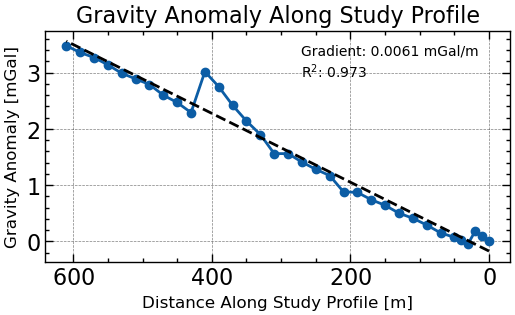

In [335]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(data['distance'], data['anomaly'], marker='o')
# Linear regression of the data
reg = LinearRegression().fit(data['distance'].values.reshape(-1, 1), data['anomaly'].values.reshape(-1, 1))
ys = reg.predict(data['distance'].values.reshape(-1, 1))
r2 = reg.score(data['distance'].values.reshape(-1, 1), data['anomaly'].values.reshape(-1, 1))
ax.plot(data['distance'], ys, color='k', linewidth=2, linestyle='--')

# Styling
ax.invert_xaxis()
ax.set_xlabel('Distance Along Study Profile [m]', fontsize=12)
ax.set_ylabel('Gravity Anomaly [mGal]', fontsize=12)
ax.set_title('Gravity Anomaly Along Study Profile')
ax.text(0.55, 0.80, f'Gradient: {reg.coef_[0][0]:.4f} mGal/m\nR$^2$: {r2:.3}', transform=ax.transAxes)
plt.savefig('fig_anomaly_profile.png', dpi=300, bbox_inches='tight')

# Figure 2: Depths from Maniscalco (2023)

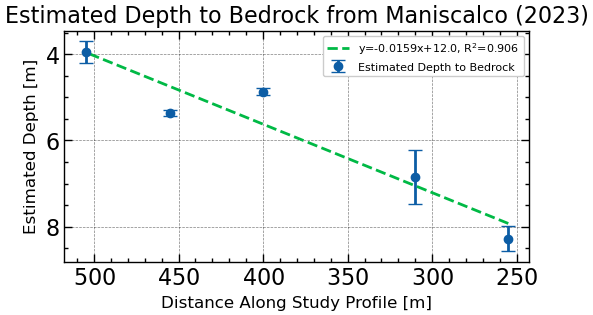

In [336]:
stat_dists_approx = np.array([255, 310, 400, 455, 505]) # in m (estimate to nearest 5 m)
depths = np.array([8.28, 6.85, 4.87, 5.36, 3.94])
depth_std = np.array([0.29, 0.62, 0.08, 0.07, 0.25])

fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(stat_dists_approx, depths, yerr=depth_std, fmt='o', capsize=5, label="Estimated Depth to Bedrock")
# Total regression
reg = LinearRegression().fit(stat_dists_approx.reshape(-1, 1),  depths.reshape(-1,1))
ys = reg.predict(stat_dists_approx.reshape(-1, 1))
r2 = reg.score(stat_dists_approx.reshape(-1, 1),  depths.reshape(-1,1))
ax.plot(stat_dists_approx.reshape(-1, 1), ys, linewidth=2, linestyle='--', label=f'y={reg.coef_[0][0]:.4f}x+{reg.intercept_[0]:.1f}, R$^2$={r2:.3}')

# Styling
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('Distance Along Study Profile [m]',fontsize=12)
ax.set_ylabel('Estimated Depth [m]', fontsize=12)
ax.set_title('Estimated Depth to Bedrock from Maniscalco (2023)')
ax.legend(loc='upper right', fontsize=8)
plt.savefig('fig_seismic_depths.png', dpi=300, bbox_inches='tight')

## Create grid

`[i, j, k] = [x, y, z]` where x is along dam, y is depth 'into' dam, and z is depth into earth

In [337]:
import numpy as np

GRID_SPACING = 1  # m --> DONT CHANGE THIS
HALF_GRID_SPACING = GRID_SPACING / 2  # m
BUFFER = 100  # m

# Define the dimensions of the array
x_size = 600 + BUFFER*2  # Number of grid points along the x-axis
y_size = 50 + BUFFER # Number of grid points along the y-axis
z_size = 5 + int(BUFFER/4) # Number of grid points along the z-axis

# Create the 3D array
# Roxbury Conglomerate = 2.62 g/cm^3 from MIT 1959 thesis
bedrock_density = 2620 # kg/m^3
densities = np.zeros((x_size, y_size, z_size))

# Determine estimated fill density
fill_density = int(((1*2000) + (0.2*2300) + (3*1000) + (3*1300))/7.2)
print(f'Estimated fill density from Maniscalco (2023): {fill_density} kg/m^3')

# Function to fill in density profile
def calculate_density(x, y, z, fill_density=fill_density, bedrock_density=bedrock_density):
    m = -0.0159
    b = 12
    b_prime = b - (m*BUFFER)
    depth = m*x + b_prime
    # ratio = (z-depth)/depth # Ratio of depth to zs
    # if abs(ratio) < 0.2: # Is depth within 20% of zs?
    #     return fill_density*(1+ratio)
    if  z < depth : # Is depth above or below line?
        return fill_density
    else:
        return bedrock_density

# Fill in the array with densities
for i in tqdm(range(x_size)):
    for j in range(y_size):
        for k in range(z_size):
            # Calculate the coordinates of the current grid point
            x = i * 1  # 1 m grid spacing along the x-axis
            y = j * 1  # 1 m grid spacing along the y-axis
            z = k * 1  # 1 m grid spacing along the z-axis
            
            # Calculate the density at the current grid point
            density = calculate_density(x, y, z)  # Replace with your density calculation function
            
            # Assign the density to the current grid point
            densities[i, j, k] = density

# Put a block at 400 m
densities[BUFFER+380:BUFFER+420, :, 5:8] = bedrock_density * 1.2

# Smooth density grid
from scipy.ndimage import gaussian_filter
densities = gaussian_filter(densities, sigma=1, mode='mirror')

print(f'Shape of the density array: {densities.shape}')

Estimated fill density from Maniscalco (2023): 1300 kg/m^3


100%|██████████| 800/800 [00:02<00:00, 345.59it/s]


Shape of the density array: (800, 150, 30)


## Figure 2: Dam Model

        Grid Spacing: 1 m
        Buffer Zone: 100 m
        Bedrock density: 2620 kg/m$^3$
        Fill density: 1300 kg/m$^3$
        Intrusion density: 3144.0 kg/m$^3$        


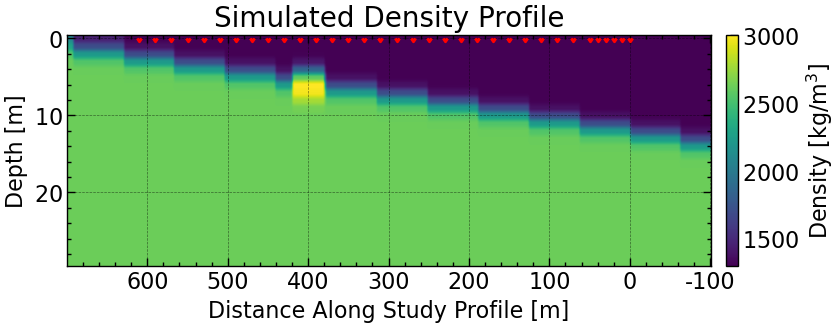

In [338]:
fig, ax = plt.subplots(figsize=(10, 3))  
c = ax.imshow(densities[:, int(y_size/2), :].T, aspect='auto', vmin=fill_density)
ax.scatter(data['distance']+BUFFER, np.zeros(data['distance'].shape), marker=11, color='red', s=10)
# Scale axis ticks to meters
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(((x-BUFFER))), ',')))
plt.colorbar(c, label=r'Density [kg/m$^3$]', orientation='vertical', pad=0.02)
# Style options
ax.invert_xaxis()
plt.margins(0,0)
ax.set_xlabel('Distance Along Study Profile [m]')
ax.set_ylabel('Depth [m]')
ax.set_title('Simulated Density Profile', fontsize=20)
plt.savefig('fig_dam_model.png', dpi=300, bbox_inches='tight')
print(f'\
        Grid Spacing: 1 m\n\
        Buffer Zone: {BUFFER} m\n\
        Bedrock density: {bedrock_density} kg/m$^3$\n\
        Fill density: {fill_density} kg/m$^3$\n\
        Intrusion density: {bedrock_density*1.2} kg/m$^3$\
        '
)

## Function to get gravity

$\Delta g = \frac{Gm}{r^3}$

In [339]:

def get_gravity_grid(point, grid):
    """
    Calculates the cumulative vertical gravitational acceleration at a given point in a 3D grid of densities.

    Args:
        point (list): Coordinates of the point [x, y, z] (in meters).
        grid (np.array): 3D grid of densities.

    Returns:
        float: Cumulative vertical gravitational acceleration at the given point (in m/s^2).
    """
    G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)

    # Get indices at every point in grid
    i, j, k = np.indices(grid.shape)
    
    # Convert indices to center of cell
    i_c = i + HALF_GRID_SPACING
    j_c = j + HALF_GRID_SPACING
    k_c = k + HALF_GRID_SPACING

    # Get the coordinates of the point
    x, y, z = point
    
    # Calculate the distances to each cell in the grid
    distances = np.sqrt((x - i_c) ** 2 + (y - j_c) ** 2 + (z - k_c) ** 2)

    # Calculate the masses of each cell in the grid
    # Spacing of grid is 1 m so mass=density grid
    masses = grid

    # Calculate the gravitational acceleration from each cell
    accelerations = G * masses / distances ** 3

    # Calculate the cumulative vertical gravitational acceleration
    cumulative_acceleration = np.sum(accelerations)
    
    # Convert to mGal
    cumulative_acceleration *= 10**5

    # return np.min(distances)
    return cumulative_acceleration

## Get gravity across the profile

In [340]:
xs = data['distance']+BUFFER
gs = np.zeros(xs.shape)
for i, x in enumerate(tqdm(xs)):
    # Use y_size/2 to get middle of the model
    gs[i] = get_gravity_grid([x, y_size/2, 0], densities)

100%|██████████| 34/34 [00:05<00:00,  6.54it/s]


Pearsons correlation: 0.981
P-value: 2.503231574470233e-24


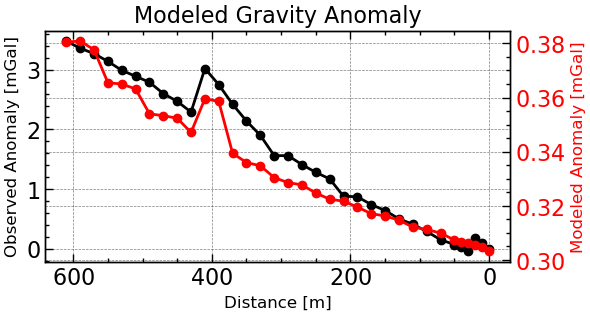

In [341]:
# Get correlation
from scipy.stats import pearsonr   
corr, pval = pearsonr(gs, data['anomaly'])
print(f'Pearsons correlation: {corr:.3f}\nP-value: {pval}')

fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.invert_xaxis()
ax1.plot(data['distance'], data['anomaly'],  marker='o', color='k')
ax2 = ax1.twinx()
ax2.plot(data['distance'], gs, marker='o', label='Modeled', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.set_xlabel('Distance [m]', fontsize=12)
ax1.set_ylabel('Observed Anomaly [mGal]', fontsize=12)
ax2.set_ylabel('Modeled Anomaly [mGal]', color='r', fontsize=12)
ax1.set_title('Modeled Gravity Anomaly')
plt.savefig('fig_modeled_anomaly.png', dpi=300, bbox_inches='tight')